# AdaBoost 

In this notebook we present our AdaBoost-model trained on the Kickstarter dataset. 

## Data Preprocessing

### Import Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import scipy as sc
from scipy.stats import kstest
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

#Data mining
import os, glob

#Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import imblearn
from imblearn.over_sampling import RandomOverSampler

## AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier


In [2]:
random_state = 100
test_size = 0.3
#sns.set(style = "white")

### Read data 

In [3]:
# Import multiple Kickstarter csv files and merge into one dataframe

path = "data-2"
all_files = glob.glob(os.path.join(path, "*.csv"))

all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('/')[-1]
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True, sort=True)

In [4]:
#
# merged_df = pd.read_csv('data-2/Kickstarter_all.csv') ### brauche ich wenn ich den Anderen Kram nicht laufen lassen will

### Data Cleaning

In [228]:
merged_df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'file', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

In [12]:
final = merged_df.copy()

#### Dropping features

Some features needed to be dropped beacause of a high amount of missing values (in some cases up to 99%). 

In [14]:
drop_list = []

drop_missing_values = ['blurb', 'friends', 'is_backing', 'is_starred', 'permissions', 'usd_type', 'location']
drop_list.extend(drop_missing_values)
final = final.drop(drop_missing_values, axis = 1)


#### Dropping useless features 

A few features needed to be dropped because they were not useful with regard to the business questions we are tackling in this project. These were for example the name or profile picture of the creator or the URL of the project itself. 

In [15]:
drop_useless_features = ['creator', 'currency_symbol', 'name', 'photo', 'profile', 'slug', 'source_url', 'urls', 'file']
drop_list.extend(drop_useless_features)
final = final.drop(drop_useless_features, axis = 1)

#### Dropping redundant features

Some of the features had to be dropped for redundancy reasons because the same information was already given at another point in the data set, like the amount that has been pledged to a project and the same amount converted to USD. 

In [16]:
drop_redundant_features = ['pledged', 'usd_pledged']
drop_list.extend(drop_redundant_features)
final = final.drop(drop_redundant_features, axis = 1)

#### Replacing or modifying features

Other features needed to be modified to extract useful information from the data set. The category variable was cleaned and modified in a way so that two new features (category and sub category) were created. 

In [18]:
def clean_category(DataFrame): 
    cat_list = []
    subcat_list = []
    for e in DataFrame.category:
        string_list = e.split(',')
        if '/' in string_list[2]:
            cat_list.append(string_list[2].split('/')[0][8:])
            subcat_list.append(string_list[2].split('/')[1][:-1])
        else:
            cat_list.append(string_list[2][8:-1])
            subcat_list.append('None')
    DataFrame['category'] = cat_list
    DataFrame['sub_category'] = subcat_list
    return DataFrame

In [19]:
modified_list = ['category','state']

In [20]:
final = clean_category(final)

In [21]:
final.category.unique()

array(['fashion', 'games', 'music', 'publishing', 'theater', 'food',
       'art', 'photography', 'technology', 'dance', 'design',
       'film & video', 'crafts', 'comics', 'journalism'], dtype=object)

Finally, the target variable (state) was filtered to only include successful or failed projects since cancelled, live or suspended projects wont help our model in its predictions with regard to our research question. 

Furthermore, boolean type variables were remodelled to integers to make them accessable for our model. 

In [22]:
final.state.replace(['successful','failed'], [1,0],inplace=True)
final = final.query('state == [1,0]')
final.state = final.state.astype(int)

final.is_starrable = final.is_starrable.astype(int)
final.disable_communication = final.disable_communication.astype(int)
final.currency_trailing_code = final.currency_trailing_code.astype(int)
final.staff_pick = final.staff_pick.astype(int)
final.spotlight = final.spotlight.astype(int)



### Time conversions



Since all of the time variables were given in Unixtime we also modified these to make them more readable for human eyes. 

In [23]:
modified_list.extend(['launched_at', 'deadline', 'created_at', 'state_changed_at'])         

In [232]:
final.launched_at = pd.to_datetime(final.launched_at,unit='s',infer_datetime_format=True)
final.deadline = pd.to_datetime(final.deadline,unit='s',infer_datetime_format=True)
final.created_at = pd.to_datetime(final.created_at,unit='s',infer_datetime_format=True)
final.state_changed_at = pd.to_datetime(final.state_changed_at,unit='s',infer_datetime_format=True)

### Summary of changes

The following dataframe gives an overview of the variables in our dataset, shows whether or not a variable was changed or dropped and marks the reason for the modification.

In [25]:
feature_list = list(merged_df.columns)

df_features = pd.DataFrame(feature_list,columns =['features'])
df_features['dropped'] = df_features.features.isin(drop_list)
df_features['drop_reason'] = ['missing_values' if x in drop_missing_values \
                              else 'useless' if x in drop_useless_features \
                              else 'redundant' if x in drop_redundant_features \
                              else 'None' for x in df_features['features']]
df_features['modified'] = df_features.features.isin(modified_list)

In [26]:
df_features

,features,dropped,drop_reason,modified
0,backers_count,False,None,False
1,blurb,True,missing_values,False
2,category,False,None,True
3,converted_pledged_amount,False,None,False
4,country,False,None,False
5,created_at,False,None,True
6,creator,True,useless,False
7,currency,False,None,False
8,currency_symbol,True,useless,False
9,currency_trailing_code,False,None,False


# Do I need this?

In [30]:
# Seperate continious vs. categorical variables
data_cat_col = ['category','country','sub_category','country','currency','current_currency','is_starrable','disable_communication','state']
data_cont_col = [x for x in final if x not in data_cat_col]
data_cat = final[data_cat_col]
data_cont = final[data_cont_col]

# Feature Engineering

Based on the given data set, we were able to create a few new variables that we considered useful with regards to our research question. These new features are:

- pledged_over: The amount of money that exceeds the preliminary set goal. 
- campaign_days: The number of days the campaign was life for
- pre_launched_days: The number of days between the creation and the launch day of the campaign. 
- launched_at_yr: The year in which the campaign launched.
- launched_at_mth: The month in which the campaign launched.
- goal_converted: The preliminary set goal amount of the campaign converted into USD. 


In [36]:
new_features_list = ['pledged_over', 'campaign_days', 'pre_launched_days', 'launched_at_yr', 'goal_converted']

In [37]:
final['pledged_over'] = final.converted_pledged_amount - final.goal 
final['campaign_days'] = ((final.deadline - final.launched_at)/ np.timedelta64(1, 'h')).astype(int)
final['pre_launched_days'] = ((final.launched_at - final.created_at)/ np.timedelta64(1, 'h')).astype(int)

final['launched_at_yr'] = [date.year for date in final['launched_at']]
final['launched_at_mth'] = [date.month for date in final['launched_at']]

final['goal_converted'] = final["goal"] * final["static_usd_rate"]

In order to counter skewed distributions some of the variables the log of the accorfing values was taken. 

In [38]:
final['goal_converted_log'] = [(math.log(el)+1) for el in final['goal_converted']]
final['converted_pledged_amount_log'] = np.log(final['converted_pledged_amount']+1)
final['backers_count_log'] = np.log(final['backers_count']+1)

# Creating a Baseline model

In order to validate our model we now want to define a baseline model that provides us with the minimum requirements for the scores of our model. This will enable us to measure the performance of our trained model.

We chose the **f1-score** as our evaluation metrics in order to account for an imbalance in our data (the distribution of our target class is about 3:2).


In [41]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192664 entries, 1 to 209221
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   backers_count                 192664 non-null  int64         
 1   category                      192664 non-null  object        
 2   converted_pledged_amount      192664 non-null  int64         
 3   country                       192664 non-null  object        
 4   created_at                    192664 non-null  datetime64[ns]
 5   currency                      192664 non-null  object        
 6   currency_trailing_code        192664 non-null  int64         
 7   current_currency              192664 non-null  object        
 8   deadline                      192664 non-null  datetime64[ns]
 9   disable_communication         192664 non-null  int64         
 10  fx_rate                       192664 non-null  float64       
 11  goal         

The categorial variables category, sub_category, currency and country were prepared as dummies to make them accesable for our model. 

In [42]:
category_dummies = pd.get_dummies(final['category'], prefix='cat', drop_first=True) 
subcategory_dummies = pd.get_dummies(final['sub_category'], prefix='subcat', drop_first=True)
currency_dummies = pd.get_dummies(final['currency'], prefix='cur', drop_first=True) 
country_dummies = pd.get_dummies(final['country'], prefix='country', drop_first=True)
final = final.drop(['category', 'sub_category', 'currency', 'country'], axis=1) 
final = pd.concat([final, category_dummies, subcategory_dummies, currency_dummies, country_dummies], axis=1) 

In the following, X and y are defined. While our target variable 'state' makes out our y, a number of variables are dropped to create our final feature list. 

The variables that feed into our training data set for our model to learn are chosen according to the business question. In order to build a predictor that is able to predict the successrate of a Kickstarter project only those variables were chosen that the creator has an impact on, eg. the month of launching or the currency the money is collected in. 

In [99]:
X = final.drop(["state", 'goal_converted', 'launched_at_yr',  'pledged_over', \
                'spotlight', 'currency_trailing_code', 'current_currency', 'created_at', \
                'deadline', 'fx_rate', 'goal', 'id', 'launched_at', 'state_changed_at', \
                'backers_count', 'backers_count_log', 'static_usd_rate', 'converted_pledged_amount_log', \
                'converted_pledged_amount'], axis=1)
y = final["state"]


The following list provides an overview of the features chosen for the training of the model:

In [235]:
X_train.columns.to_list()

['disable_communication',
 'is_starrable',
 'staff_pick',
 'campaign_days',
 'pre_launched_days',
 'launched_at_mth',
 'goal_converted_log',
 'cat_comics',
 'cat_crafts',
 'cat_dance',
 'cat_design',
 'cat_fashion',
 'cat_film & video',
 'cat_food',
 'cat_games',
 'cat_journalism',
 'cat_music',
 'cat_photography',
 'cat_publishing',
 'cat_technology',
 'cat_theater',
 'subcat_None',
 'subcat_academic',
 'subcat_accessories',
 'subcat_action',
 'subcat_animals',
 'subcat_animation',
 'subcat_anthologies',
 'subcat_apparel',
 'subcat_apps',
 'subcat_architecture',
 'subcat_art books',
 'subcat_audio',
 'subcat_bacon',
 'subcat_blues',
 'subcat_calendars',
 'subcat_camera equipment',
 'subcat_candles',
 'subcat_ceramics',
 "subcat_children's books",
 'subcat_childrenswear',
 'subcat_chiptune',
 'subcat_civic design',
 'subcat_classical music',
 'subcat_comedy',
 'subcat_comic books',
 'subcat_community gardens',
 'subcat_conceptual art',
 'subcat_cookbooks',
 'subcat_country & folk',
 's

Next, we split our data set in train and test set:

In [100]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True,
                                                        stratify=y)

## Dummy Classifier

We chose a dummy classifier as our baseline model. It was customized as to only predict the minority class in order to set a good threshold for the score we needed to beat. As you can see in the following classification report our model needs to beat an f1-score of 0.76. 

In [101]:
# create a dummy classifier model as Basemodel
dum_clf = DummyClassifier(strategy='constant',constant=1).fit(X_train,y_train)
y_pred_dum_clf = dum_clf.predict(X_test)

print(confusion_matrix(y_test,y_pred_dum_clf))
print(classification_report(y_test,y_pred_dum_clf))


[[    0 22560]
 [    0 35240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22560
           1       0.61      1.00      0.76     35240

    accuracy                           0.61     57800
   macro avg       0.30      0.50      0.38     57800
weighted avg       0.37      0.61      0.46     57800



## Tackling imbalance: Oversampling

In order to deal with the imbalance in our datset we used a random oversampler to balance the target classes in the trainings set. 

In [102]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=random_state)
X_train_over, y_train_over = oversample.fit_resample(np.array(X_train), np.array(y_train))

Primarily, a few features were scaled and saved in an additional training data set. We will compare the performance of our model with scaled and unscaled variables later. Note that after the feature selection none of the scaled variables remained on our X, so the following code wont be executed.

In [50]:
features_scalable_list = ['goal_converted']

In [103]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [ ]:
scaler = StandardScaler()
X_train_scaled[features_scalable_list] = scaler.fit_transform(np.array(X_train[features_scalable_list])) # Scaler is fitted to training data _only_
X_test_scaled[features_scalable_list] = scaler.transform(np.array(X_test[features_scalable_list])) # Already fitted scaler is applied to test data

# Predictive Modelling: AdaBoost


As metioned above we use the F1-Score as evaluation metric. In the following we train an AdaBoost model, fine tuning it with different training sets and look for the optimal parameters with a grid search. 

In [105]:
#AdaBoost
X_train.head()

,disable_communication,is_starrable,staff_pick,campaign_days,pre_launched_days,launched_at_mth,goal_converted_log,cat_comics,cat_crafts,cat_dance,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
207856,0,0,0,600,2246,4,7.910230,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179860,0,0,1,1175,159,7,11.126631,0,0,0,...,0,0,0,0,0,0,0,0,0,1
36509,0,0,0,720,142,8,10.210340,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24237,0,0,0,720,2143,8,11.308953,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13252,0,0,0,720,1379,3,11.819778,0,0,0,...,0,0,0,0,0,0,0,0,0,1


First, we initiate the fist model with some standard parameters and get the performance.

In [86]:
adaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=0.4, random_state=1)
model = adaB.fit(X_train_scaled, y_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134864 entries, 207856 to 33035
Columns: 201 entries, disable_communication to country_US
dtypes: float64(2), int64(7), uint8(192)
memory usage: 35.0 MB


In [70]:
def generic_clf(X_train, Y_train, X_test, Y_test, clf):
    mod = clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    print(f1_score(Y_test, pred_test))
    print(classification_report(Y_test, pred_test)) 
    print(confusion_matrix(Y_test, pred_test))
    sns.heatmap(confusion_matrix(Y_test, pred_test), annot=True, cmap='YlGn', fmt='d');
    return pred_train, pred_test

In [98]:
# the following 2 modells use the features 
first_features_list = ['disable_communication',
 'is_starrable',
 'staff_pick',
 'campaign_days',
 'pre_launched_days',
 'launched_at_yr',
 'launched_at_mth',
 'goal_converted',
 'goal_converted_log',
 'cat_comics',
 'cat_crafts',
 'cat_dance',
 'cat_design',
 'cat_fashion',
 'cat_film & video',
 'cat_food',
 'cat_games',
 'cat_journalism',
 'cat_music',
 'cat_photography',
 'cat_publishing',
 'cat_technology',
 'cat_theater',
 'subcat_None',
 'subcat_academic',
 'subcat_accessories',
 'subcat_action',
 'subcat_animals',
 'subcat_animation',
 'subcat_anthologies',
 'subcat_apparel',
 'subcat_apps',
 'subcat_architecture',
 'subcat_art books',
 'subcat_audio',
 'subcat_bacon',
 'subcat_blues',
 'subcat_calendars',
 'subcat_camera equipment',
 'subcat_candles',
 'subcat_ceramics',
 "subcat_children's books",
 'subcat_childrenswear',
 'subcat_chiptune',
 'subcat_civic design',
 'subcat_classical music',
 'subcat_comedy',
 'subcat_comic books',
 'subcat_community gardens',
 'subcat_conceptual art',
 'subcat_cookbooks',
 'subcat_country & folk',
 'subcat_couture',
 'subcat_crochet',
 'subcat_digital art',
 'subcat_diy',
 'subcat_diy electronics',
 'subcat_documentary',
 'subcat_drama',
 'subcat_drinks',
 'subcat_electronic music',
 'subcat_embroidery',
 'subcat_events',
 'subcat_experimental',
 'subcat_fabrication tools',
 'subcat_faith',
 'subcat_family',
 'subcat_fantasy',
 "subcat_farmer's markets",
 'subcat_farms',
 'subcat_festivals',
 'subcat_fiction',
 'subcat_fine art',
 'subcat_flight',
 'subcat_food trucks',
 'subcat_footwear',
 'subcat_gadgets',
 'subcat_gaming hardware',
 'subcat_glass',
 'subcat_graphic design',
 'subcat_graphic novels',
 'subcat_hardware',
 'subcat_hip-hop',
 'subcat_horror',
 'subcat_illustration',
 'subcat_immersive',
 'subcat_indie rock',
 'subcat_installations',
 'subcat_interactive design',
 'subcat_jazz',
 'subcat_jewelry',
 'subcat_kids',
 'subcat_knitting',
 'subcat_latin',
 'subcat_letterpress',
 'subcat_literary journals',
 'subcat_literary spaces',
 'subcat_live games',
 'subcat_makerspaces',
 'subcat_metal',
 'subcat_mixed media',
 'subcat_mobile games',
 'subcat_movie theaters',
 'subcat_music videos',
 'subcat_musical',
 'subcat_narrative film',
 'subcat_nature',
 'subcat_nonfiction',
 'subcat_painting',
 'subcat_people',
 'subcat_performance art',
 'subcat_performances',
 'subcat_periodicals',
 'subcat_pet fashion',
 'subcat_photo',
 'subcat_photobooks',
 'subcat_places',
 'subcat_playing cards',
 'subcat_plays',
 'subcat_poetry',
 'subcat_pop',
 'subcat_pottery',
 'subcat_print',
 'subcat_printing',
 'subcat_product design',
 'subcat_public art',
 'subcat_punk',
 'subcat_puzzles',
 'subcat_quilts',
 'subcat_r&b',
 'subcat_radio & podcasts',
 'subcat_ready-to-wear',
 'subcat_residencies',
 'subcat_restaurants',
 'subcat_robots',
 'subcat_rock',
 'subcat_romance',
 'subcat_science fiction',
 'subcat_sculpture',
 'subcat_shorts',
 'subcat_small batch',
 'subcat_software',
 'subcat_sound',
 'subcat_space exploration',
 'subcat_spaces',
 'subcat_stationery',
 'subcat_tabletop games',
 'subcat_taxidermy',
 'subcat_television',
 'subcat_textiles',
 'subcat_thrillers',
 'subcat_translations',
 'subcat_typography',
 'subcat_vegan',
 'subcat_video',
 'subcat_video art',
 'subcat_video games',
 'subcat_wearables',
 'subcat_weaving',
 'subcat_web',
 'subcat_webcomics',
 'subcat_webseries',
 'subcat_woodworking',
 'subcat_workshops',
 'subcat_world music',
 'subcat_young adult',
 'subcat_zines',
 'cur_CAD',
 'cur_CHF',
 'cur_DKK',
 'cur_EUR',
 'cur_GBP',
 'cur_HKD',
 'cur_JPY',
 'cur_MXN',
 'cur_NOK',
 'cur_NZD',
 'cur_SEK',
 'cur_SGD',
 'cur_USD',
 'country_AU',
 'country_BE',
 'country_CA',
 'country_CH',
 'country_DE',
 'country_DK',
 'country_ES',
 'country_FR',
 'country_GB',
 'country_HK',
 'country_IE',
 'country_IT',
 'country_JP',
 'country_LU',
 'country_MX',
 'country_NL',
 'country_NO',
 'country_NZ',
 'country_SE',
 'country_SG',
 'country_US']

First we are going to compare the scaled and unscaled varieties of our training set and measure their performance:

0.8327498523288815
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     22560
           1       0.85      0.82      0.83     35240

    accuracy                           0.80     57800
   macro avg       0.79      0.79      0.79     57800
weighted avg       0.80      0.80      0.80     57800

[[17290  5270]
 [ 6339 28901]]


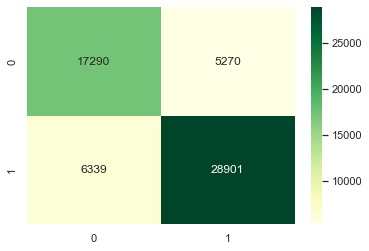

In [77]:
adamodel = generic_clf(X_train, y_train, X_test, y_test, adaB)

0.8327498523288815
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     22560
           1       0.85      0.82      0.83     35240

    accuracy                           0.80     57800
   macro avg       0.79      0.79      0.79     57800
weighted avg       0.80      0.80      0.80     57800

[[17290  5270]
 [ 6339 28901]]


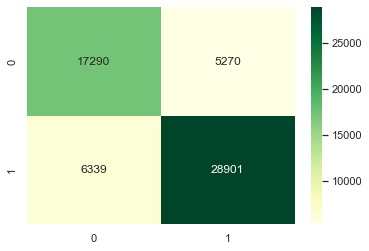

In [76]:
adamodel_scaled = generic_clf(X_train_scaled, y_train, X_test_scaled, y_test, adaB)

0.8421679233516639
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     22560
           1       0.84      0.84      0.84     35240

    accuracy                           0.81     57800
   macro avg       0.80      0.80      0.80     57800
weighted avg       0.81      0.81      0.81     57800

[[16954  5606]
 [ 5530 29710]]


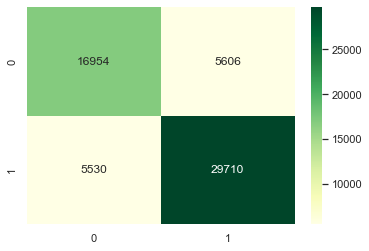

In [111]:
adaB_opt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth= 3, min_samples_split = 4), \
                          n_estimators=120, learning_rate=0.5, random_state=1,)
model_opt = adaB_opt.fit(X_train, y_train)

adamodel_opt = generic_clf(X_train, y_train, X_test, y_test, adaB_opt)


## Adaboost with oversampling

0.8403443009857005
              precision    recall  f1-score   support

           0       0.76      0.71      0.74     22560
           1       0.82      0.86      0.84     35240

    accuracy                           0.80     57800
   macro avg       0.79      0.78      0.79     57800
weighted avg       0.80      0.80      0.80     57800

[[16035  6525]
 [ 4975 30265]]


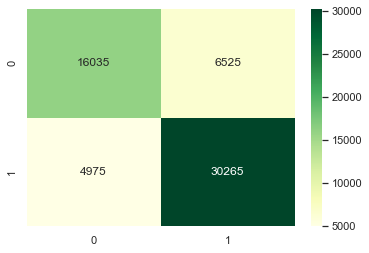

In [237]:
adaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=0.4, random_state=1)
adamodel_oversamp = generic_clf(X_train_over, y_train_over, X_test, y_test, adaB)

GridSearch with oversampling:

In [248]:
parameters3 = {'n_estimators':[120, 150],                
              'learning_rate':[0.4, 0.5],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)               
             }
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
scorer = make_scorer(f1_score)
grid3 = GridSearchCV(clf, parameters3, verbose=True, scoring = scorer)

result3 = grid3.fit(X_train_over, y_train_over)

print('Best Parameters:', result3.best_params_)
print('Best Score:', result3.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.5, 'n_estimators': 150}
Best Score: 0.8022356725940345


0.8200918537054271
              precision    recall  f1-score   support

           0       0.70      0.85      0.76     22560
           1       0.89      0.76      0.82     35240

    accuracy                           0.80     57800
   macro avg       0.79      0.81      0.79     57800
weighted avg       0.81      0.80      0.80     57800

[[19135  3425]
 [ 8366 26874]]


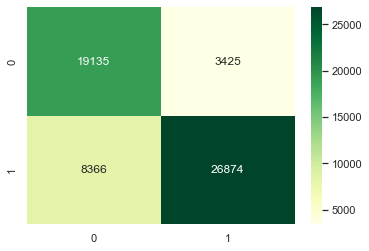

In [240]:
adaB_opt2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth= 3, min_samples_split = 6), \
                          n_estimators=120, learning_rate=0.5, random_state=1,)
model_opt2 = adaB_opt2.fit(X_train_over, y_train_over)

adamodel_opt2 = generic_clf(X_train_over, y_train_over, X_test, y_test, adaB_opt2)

In [140]:
features_used = X_train.columns.tolist()

In [226]:
np.array(to_predict_new)
to_predict_new.head()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,to_predict_df
NaN,disable_communication,is_starrable,staff_pick,campaign_days,pre_launched_days,launched_at_mth,goal_converted_log,cat_comics,cat_crafts,cat_dance,cat_design,cat_fashion,cat_film & video,cat_food,cat_games,cat_journalism,cat_music,cat_photography,cat_publishing,cat_technology,cat_theater,subcat_None,subcat_academic,subcat_accessories,subcat_action,subcat_animals,subcat_animation,subcat_anthologies,subcat_apparel,subcat_apps,subcat_architecture,subcat_art books,subcat_audio,subcat_bacon,subcat_blues,subcat_calendars,subcat_camera equipment,subcat_candles,subcat_ceramics,subcat_children's books,subcat_childrenswear,subcat_chiptune,subcat_civic design,subcat_classical music,subcat_comedy,subcat_comic books,subcat_community gardens,subcat_conceptual art,subcat_cookbooks,subcat_country & folk,subcat_couture,subcat_crochet,subcat_digital art,subcat_diy,subcat_diy electronics,subcat_documentary,subcat_drama,subcat_drinks,subcat_electronic music,subcat_embroidery,subcat_events,subcat_experimental,subcat_fabrication tools,subcat_faith,subcat_family,subcat_fantasy,subcat_farmer's markets,subcat_farms,subcat_festivals,subcat_fiction,subcat_fine art,subcat_flight,subcat_food trucks,subcat_footwear,subcat_gadgets,subcat_gaming hardware,subcat_glass,subcat_graphic design,subcat_graphic novels,subcat_hardware,subcat_hip-hop,subcat_horror,subcat_illustration,subcat_immersive,subcat_indie rock,subcat_installations,subcat_interactive design,subcat_jazz,subcat_jewelry,subcat_kids,subcat_knitting,subcat_latin,subcat_letterpress,subcat_literary journals,subcat_literary spaces,subcat_live games,subcat_makerspaces,subcat_metal,subcat_mixed media,subcat_mobile games,subcat_movie theaters,subcat_music videos,subcat_musical,subcat_narrative film,subcat_nature,subcat_nonfiction,subcat_painting,subcat_people,subcat_performance art,subcat_performances,subcat_periodicals,subcat_pet fashion,subcat_photo,subcat_photobooks,subcat_places,subcat_playing cards,subcat_plays,subcat_poetry,subcat_pop,subcat_pottery,subcat_print,subcat_printing,subcat_product design,subcat_public art,subcat_punk,subcat_puzzles,subcat_quilts,subcat_r&b,subcat_radio & podcasts,subcat_ready-to-wear,subcat_residencies,subcat_restaurants,subcat_robots,subcat_rock,subcat_romance,subcat_science fiction,subcat_sculpture,subcat_shorts,subcat_small batch,subcat_software,subcat_sound,subcat_space exploration,subcat_spaces,subcat_stationery,subcat_tabletop games,subcat_taxidermy,subcat_television,subcat_textiles,subcat_thrillers,subcat_translations,subcat_typography,subcat_vegan,subcat_video,subcat_video art,subcat_video games,subcat_wearables,subcat_weaving,subcat_web,subcat_webcomics,subcat_webseries,subcat_woodworking,subcat_workshops,subcat_world music,subcat_young adult,subcat_zines,cur_CAD,cur_CHF,cur_DKK,cur_EUR,cur_GBP,cur_HKD,cur_JPY,cur_MXN,cur_NOK,cur_NZD,cur_SEK,cur_SGD,cur_USD,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
1.0,0,0,0,31,40,3,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
#compression_opts = dict(method='zip', archive_name='Kickstarter_all_clean.csv')  
future_projects_tr.to_csv('data-2/Future_projects.csv', index=False)

## Feature Importance

Get the most important features for our model with Feature Importnace: 

In [244]:
important_features_opt = model_opt.feature_importances_.tolist()
feature_names_opt = X_train.columns.to_list()
feature_df = pd.DataFrame(important_features_opt, feature_names_opt)

,0
disable_communication,0.000000e+00
is_starrable,0.000000e+00
staff_pick,3.024450e-02
campaign_days,1.105011e-01
pre_launched_days,9.232010e-02
...,...
country_NO,0.000000e+00
country_NZ,6.523182e-04
country_SE,1.214317e-14
country_SG,0.000000e+00


In [131]:
feature_ranking = feature_df.sort_values(0, ascending=False)

In [231]:
feature_ranking.head(55)

,0
goal_converted_log,0.207339
campaign_days,0.110501
pre_launched_days,0.092320
launched_at_mth,0.049395
staff_pick,0.030244
cur_EUR,0.010957
subcat_narrative film,0.010284
cat_theater,0.010248
subcat_accessories,0.010157
cur_USD,0.010066


In [85]:
# GridSearch

parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             }
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
scorer = make_scorer(f1_score)
grid = GridSearchCV(clf, parameters, verbose=True, scoring = scorer)

result = grid.fit(X_train, y_train)

print('Best Parameters:', result.best_params_)
print('Best Score:', result.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.5, 'n_estimators': 120}
Best Score: 0.8554056873636828


Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.5, 'n_estimators': 120}

Best Score: 0.8554056873636828

In [92]:
# Further GridSearch

parameters2 = {'n_estimators':[120, 150],                
              'learning_rate':[0.4, 0.5],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)               
             }
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
scorer = make_scorer(f1_score)
grid2 = GridSearchCV(clf, parameters2, verbose=True, scoring = scorer)

result2 = grid.fit(X_train, y_train)

print('Best Parameters:', result2.best_params_)
print('Best Score:', result2.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 4, 'learning_rate': 0.5, 'n_estimators': 120}
Best Score: 0.855410944870415


This model can now be used to predict the success rate of future Kickstarter projects.